The present hands on lab mainly uses [Immigration to Canada dataset](https://developer.ibm.com/exchanges/data/all/airline/) and employ advanced visualization tools such as word cloud, and waffle plot to display relations between features within the dataset.   

This hands on practice is a part of [Data Visualization with Python](https://www.coursera.org/learn/python-for-data-visualization?) course offered by [Coursera.org](https://www.coursera.org/).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mtp
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS
import urllib
from PIL import Image
import folium
from folium import plugins
import wget
import plotly.graph_objects as go
import plotly.express as px
import dash
import dash_html_components as html
import dash_core_components as dcc
%matplotlib inline

In [2]:
# importing the "Immigration to Canada" csv dataset as a dataframe using pandas library
url =  'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Canada.xlsx'
df = pd.read_excel(url,sheet_name='Canada by Citizenship', skiprows=20)

## Data Wrangling

In [3]:
# let's make a list of the columns that should be dropped
col_drop = df.iloc[:,43:].columns.to_list()
col_drop.append('Type')
col_drop.append('DEV')
# let's drop the columns from col_drop list
df.drop(col_drop, axis=1, inplace=True)
# let's drop the last two rows
df.drop(df.tail(2).reset_index()['index'].to_list(), axis=0, inplace=True)

In [18]:
# let's change the name first few columns of the dataset
col_name={'AREA':'area','OdName':'List of countries','Coverage':'immigration_status',
          'AreaName':'continent','REG':'region_num','RegName':'region_name',
          'DevName':'development_status'}
df.rename(columns = col_name,inplace=True)
# let's shorten the name of a few countries
df.rename(index={'Iran (Islamic Republic of)':'Iran',
                 'United Kingdom of Great Britain and Northern Ireland':'UK',
                'Latin America and the Caribbean':'South America'}, inplace=True)

In [5]:
df['total']=df.iloc[:,7:].sum(axis=1)# let's add a column of the total immigration by each country
df.set_index('List of countries',inplace=True) # let's set the index of the dataframe to the lsit of countries
years = list(range(1980, 2014)) # let's create a list of years from 1980 to 2014.

## Visualization

In [6]:
mtp.style.use('ggplot') # let's set the style of matplotlib plots to ggplot

### Bubble plot

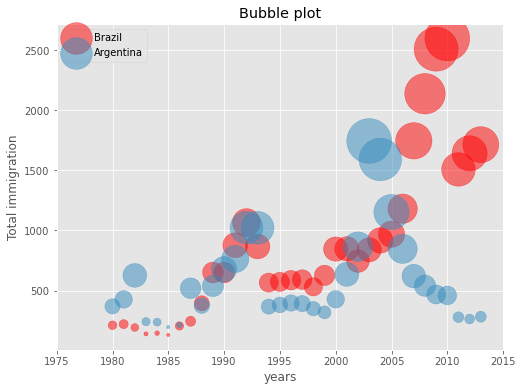

In [16]:
df_ab = df.loc[['Brazil','Argentina'],years].transpose().reset_index()
df_ab['norm Brazil'] = (df_ab['Brazil']-df_ab['Brazil'].min())/(df_ab['Brazil'].max()-df_ab['Brazil'].min())
df_ab['norm Argentina'] = (df_ab['Argentina']-df_ab['Argentina'].min())/(df_ab['Argentina'].max()-df_ab['Argentina'].min())
df_ab.rename(columns={'index':'years'}, inplace=True)
ax = df_ab.plot(kind='scatter',x='years',y='Brazil',s=df_ab['norm Brazil']*2000+10, xlim=(1975,2015), color='red',alpha=0.5)
df_ab.plot(kind='scatter',x='years',y='Argentina',s=df_ab['norm Argentina']*2000+10, xlim=(1975,2015),ax=ax,alpha=0.5,figsize=(8,6))
ax.legend(['Brazil','Argentina'], loc='upper left')
ax.set_title('Bubble plot')
ax.set_ylabel('Total immigration')
plt.show()

**Discussion**: The bubble plot above shows two jumps in years 1990 to 1995 and and 2003 to 2010 which could reflect the economic condition of Brazil and Argentina during these years. Also, the number of immigration from Argentina decreases after 2003 indicating that some sort of economic recovery plan in the country.  

### Waffle Chart

<Figure size 432x288 with 0 Axes>

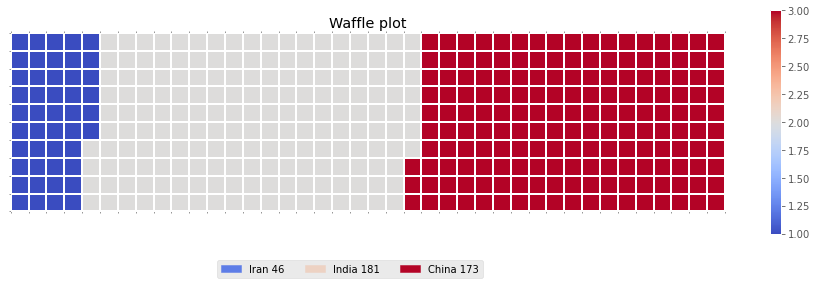

In [22]:
def waffle_plot(countries, w, h):
    fig = plt.figure()
    df_dns = df.loc[list_of_countries]
    df_dns_sum = df_dns['total'].sum()
    country_proportion = df_dns['total']/df_dns_sum
    ##
    width = w
    height = h
    total_tile_num = w*h
    tile_num_per_country = (country_proportion*total_tile_num).round().astype(int)
    ##
    waffle_chart = np.zeros((h,w), dtype=np.uint)
    category_num = 0
    col_index = 0
    row_index = 0
    for col in range(w):
        col_index+=1
        for row in range(height):
            row_index+=1
            if row_index>sum(tile_num_per_country[0:category_num]):
                category_num+=1
            waffle_chart[row,col] = category_num
    ##
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap = colormap)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, w,1), minor=True)
    ax.set_yticks(np.arange(-0.5, h,1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.set_title('Waffle plot')
    plt.xticks([])
    plt.yticks([])
    ##
    cumsum= np.cumsum(df_dns['total'])
    total_cumsum = cumsum[len(cumsum)-1]
    legen_handle = []
    color_value = []
    for i, country in enumerate(tile_num_per_country.index.values):
        legen_handle.append(mpatches.Patch(label=(country+" "+str(tile_num_per_country[i])), color = colormap(float(cumsum[i]/total_cumsum))))
    plt.legend(handles = legen_handle, loc='lower center', ncol=len(countries), bbox_to_anchor=(0, -0.4, 0.95,1))
    plt.show()
list_of_countries = ['Iran', 'India', 'China']
waffle_plot(list_of_countries, 40, 10)   

**Display**: The waffle plot shown above presents an interesting display of immigration from India, China, and Iran. This plot could be a great way to show a live incremental change in contribution of a feature for instance in presidential elections.

### Word Cloud

In [27]:
# let's make a text file with max 200 words
# where, based on the contribution of each country in immigration to Canada, the name of the country is accordingly repeated.
total_sum = df['total'].sum(axis=0)
max_word = 200 
df_text = ' '
for country in df.index.values:
    if " " not in country:
        contribute = int((df.loc[country,'total']/total_sum)*max_word)
        df_text = df_text + (country+' ')*contribute
stop_words = set(STOPWORDS)
# let's instantiate the word cloud
word_cloud1 = WordCloud(background_color='white', max_words=max_word, stopwords=stop_words)
word_cloud1.generate(df_text) # let's generate a word cloud

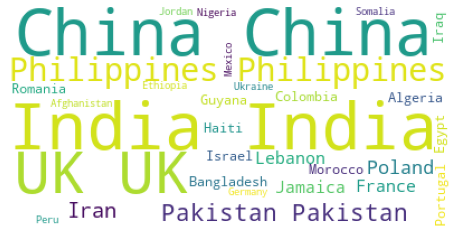

In [28]:
fig = plt.figure(figsize=(8,6))
plt.imshow(word_cloud1, cmap=plt.cm.coolwarm)
plt.axis('off')
plt.show()

**Discussion**: In word cloud above words with larger and bolder fonts indicate higher frequencies within the text file. As such, China, India, and UK are repeated the most. As such, they have the highest number of immigration to Canada from 1980 to 2013.

In [29]:
# this time let's import a text file of a novel
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/alice_novel.txt'
text = urllib.request.urlopen(url).read().decode('utf-8')

In [30]:
# using stopwords some words that are not important (e.g., said) are removed from analyses
stopwords = set(STOPWORDS)
stopwords.add('Said')

In [31]:
# the word cloud display could have any shape. Since the novel is Alice in Wonderland, then let's find an Alice image.
url_img = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/labs/Module%204/images/alice_mask.png'
alice_mask = np.array(Image.open(urllib.request.urlopen(url_img)))

In [34]:
# let's instantiate the word cloud
word_cloud2 = WordCloud(mask=alice_mask, background_color='white', stopwords=stopwords, max_words=1000) 
word_cloud2.generate(text) # let's generate the word cloud

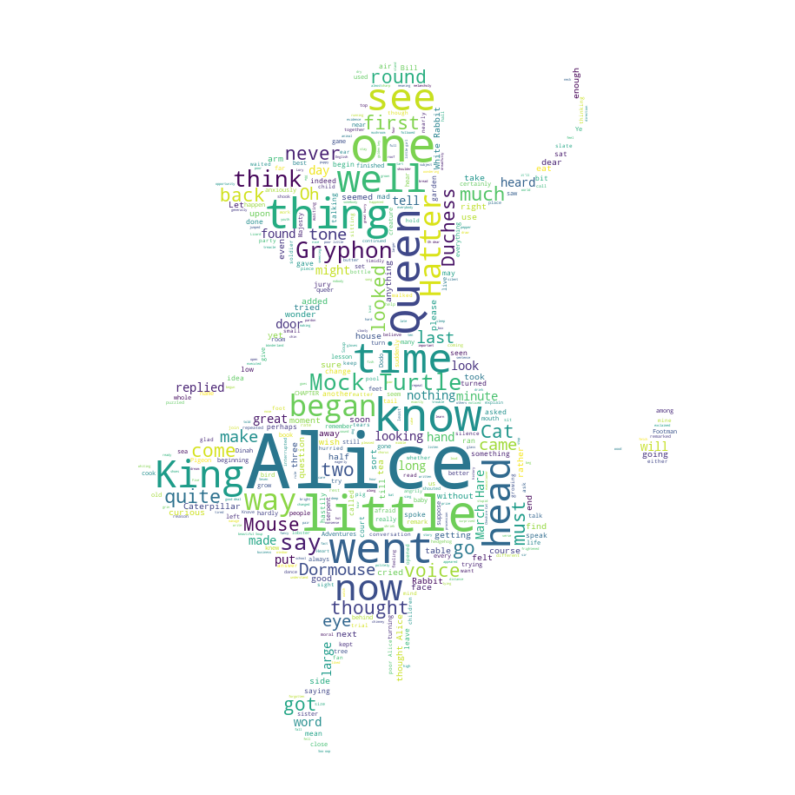

In [35]:
fig=plt.figure(figsize=(14,18))
plt.imshow(word_cloud2, interpolation='bilinear', cmap = plt.cm.coolwarm)
plt.axis('off')
plt.show()

**Discussion**: The word cloud plot above presents an interesting display of words distribution in the novel. As could be expected, the word Alice is repeated the most.

### Map Visualizations using Folium

In [50]:
# let's plot a map of Canada
Canada_map = folium.Map(location = [56.1304, -95], zoom_start=4, tiles = 'Stamen Terrain')
# let's mark Calgary (where I live) in the map
Calgary = folium.map.FeatureGroup()
Calgary.add_child(folium.features.CircleMarker([51.0447, -114.0719], radius=5, color='blue', fill_color = "Red"))
Canada_map.add_child(ontorio)
folium.Marker([51.0447, -114.0719], popup='Ontorio').add_to(Canada_map)
Canada_map

In [52]:
# now let's mark the crime locations in the city of Sanfransisco
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Police_Department_Incidents_-_Previous_Year__2016_.csv'
df_crime = pd.read_csv(url)

In [53]:
df_incident = df_crime.loc[:100]
longitudie = df_incident.X
latitude = df_incident.Y
Address = df_incident.Address
##
SanFran_map = folium.Map(location=[37.7749,-122.4194], zoom_start=12) # let's generate the map of San Fransisco
inci = plugins.MarkerCluster().add_to(SanFran_map) # let's cluster the mark point that are close to each other
for lat,lon,address in zip(latitude, longitudie, Address):
    crime_loc = folium.map.FeatureGroup().add_child(
        folium.features.CircleMarker([lat, lon],radius=4,color='blue',fill=True,
                                     fill_color='blue',fill_opacity=1.0,popup=address))
    folium.Marker([lat, lon], popup=address).add_to(inci)
    SanFran_map.add_child(crime_loc)
SanFran_map

**Discussion**: In the plot above, zones based on the number of crimes are colored. By zooming in the map, we can see different cluster nodes and by clicking on each mark point we can see the location of the crime.

### Choropleth maps

In [54]:
# let's see the distribution of immigration to Canada from 1980 to 2013 using map plot
# first we need a jason file including the lat and long locations (edges) of each country in the world.
! wget --quiet https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/world_countries.json
print('download has completed')    

download has completed


In [60]:
threshold = np.linspace(df['total'].min(),df['total'].max(),6) # let's set a threshold to divide the color bar into 6 sections.
threshold[-1]=threshold[-1]+1 # since the color bars starts with 1, we need to add 1 to the end of the total immigration number
##
world_geo = r'world_countries.json'
world_map = folium.Map(location=[0,0], zoom_start=2)
world_map.choropleth(
    geo_data=world_geo
    ,data=df.reset_index(),columns=['List of countries','total']
    ,key_on='feature.properties.name'
    ,fill_color='YlOrRd'
    ,fill_opacity = 0.7
    ,line_opacity=0.2
    ,legend_name='Immigration to Canada'
    ,reset=True
    ,threshold_scale = threshold)
world_map

**Discussion**: The map plot above shows that India and China has the highest number of immigration to Canada from 1980 to 2013.

### Plotly (Interactive Graphing)

In [82]:
# sun burst plot is a very interesting way to show the distribution of each feature within the dataset.
# using plotly express the subburst plot below is interative.
fig = px.sunburst(df.iloc[:10].reset_index(), path=['continent','region_name','List of countries'],
              values='total',title='Sunburst plot')
fig.show()

In [85]:
# treemap also provides a similar interactive plot
fig = px.treemap(df.iloc[:10].reset_index(), path=['continent','region_name','List of countries'],
              values='total',title='Treemap plot')
fig.show()